# Scope of this notebook

This notebook builds on earlier tutorials and focuses on understanding how PyTorch autograd represents and traverses computation graphs.

In particular, it introduces the **directed acyclic graph (DAG)** underlying automatic differentiation and shows how gradients are propagated through this graph during backpropagation.

The emphasis is on developing conceptual intuition for:
- how computation graphs are constructed dynamically,
- how backward functions (`grad_fn`) are linked together,
- how gradients flow through operations and terminate at leaf tensors,
- and how PyTorch supports higher-order differentiation.

Key topics covered include:
- the structure of computation graphs (nodes, edges, roots, and leaves),
- the role of `grad_fn` and `next_functions`,
- tracing gradient flow through the DAG,
- dynamic graph construction in PyTorch (define-by-run),
- and computing higher-order derivatives using `create_graph=True`.

This notebook is intended as a conceptual bridge between:
- basic gradient-based learning (Tutorial 2),
- and more advanced topics such as Jacobians, Hessians, and optimisation methods.

It does not cover neural network modules, datasets, optimisers, or training pipelines, which are better addressed separately once the foundations of autograd are firmly understood.

Recommended prerequisites:
- Familiarity with PyTorch tensors
- Basic understanding of backpropagation and first-order gradients

---

**Author:** Angze Li

**Last updated:** 2026-02-03

**Version:** v1.0

In [2]:
import torch

### Understanding the Computational Graph (DAG) in `Autograd`
In the context of deep learning, `Autograd` uses a **Directed Acyclic Graph (DAG)** to keep track of every operation performed on your data. This graph is the blueprint that allows the system to calculate gradients through *backpropagation*.

Key Components of the DAG:

- **Nodes**: These represent **Tensors** (the data) and **Functions** (the operations like addition, multiplication, or activation functions).

- **Edges**: These represent the flow of data from one operation to the next.

- **Leaves**: The input tensors (usually your **model parameters/weights**).

- **Roots**: The final output tensor (usually your **Loss value**).

Why **"Directed"** and **"Acyclic"**?

- **Directed**: The data flows in a specific direction—from inputs to outputs during the forward pass, and from the loss back to the inputs during the backward pass.

- **Acyclic**: The graph cannot have loops. If it did, the chain rule would enter an infinite loop, and you could never finish calculating a gradient.

The Two Phases:

1. **Forward Pass**: You perform math. Autograd records these operations and builds the grad_fn (gradient function) for each resulting tensor.

2. **Backward Pass**: You call `.backward()` on the root. Autograd traverses the graph in reverse, applying the Chain Rule to compute how much each leaf tensor contributed to the final result.

<div>
  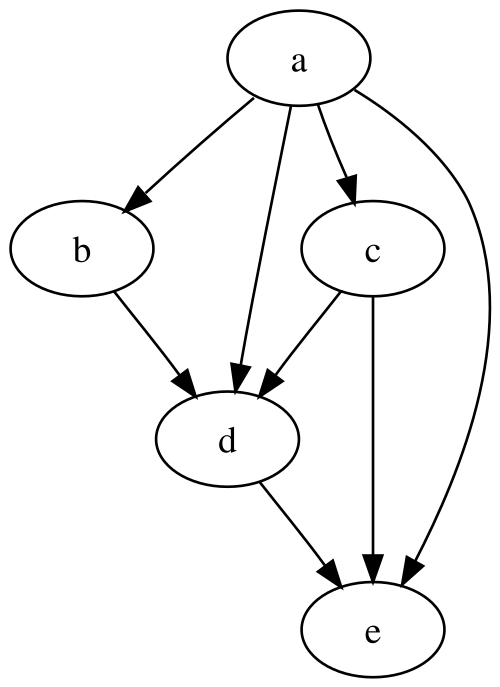
  <p style="text-align: center; font-size: 0.9em;">
    <strong>Figure 1.</strong> Example of a directed acyclic graph. Figure taken from Wikipedia.
  </p>
</div>

In [11]:
# 1. Inputs: 2x3 Matrix (e.g., a batch of 2 inputs with 3 features each)
x = torch.randn(2, 3, requires_grad=True)

# 2. Weights: 3x2 Matrix (to transform output to size 2x2)
w = torch.randn(3, 2, requires_grad=True)

# 3. Forward Pass: Matrix Multiplication (mm)
y = torch.mm(x, w) 

# 4. Addition (Bias)
z = y + 2.0

# 5. Reduction: Most DAGs end in a scalar 'Loss'
# The mean() operation is a node in the DAG!
loss = z.mean()

print(f"Forward Pass Result (Loss): {loss.item()}")
print(f"Leaf grad before backward: x.grad = {x.grad}") # Returns None

# 4. The Backward Pass
# This populates the .grad attributes throughout the graph
loss.backward()

# 5. Inspecting the Gradients
print("-" * 30)
print(f"Gradient of Loss w.r.t x:\n{x.grad}")
print(f"Gradient of Loss w.r.t w:\n{w.grad}")

# 6. Checking the 'grad_fn' chain (The DAG structure)
print("-" * 30)
print(f"Root (Loss) Op: {loss.grad_fn}")
print(f"Next Op (Add):  {loss.grad_fn.next_functions[0][0]}")
print(f"Next Op (MM):   {loss.grad_fn.next_functions[0][0].next_functions[0][0]}")

Forward Pass Result (Loss): 2.6581220626831055
Leaf grad before backward: x.grad = None
------------------------------
Gradient of Loss w.r.t x:
tensor([[ 0.0056,  0.4392, -0.4450],
        [ 0.0056,  0.4392, -0.4450]])
Gradient of Loss w.r.t w:
tensor([[ 0.0911,  0.0911],
        [-0.0316, -0.0316],
        [-0.3998, -0.3998]])
------------------------------
Root (Loss) Op: <MeanBackward0 object at 0x1089df130>
Next Op (Add):  <AddBackward0 object at 0x1089dee90>
Next Op (MM):   <MmBackward0 object at 0x1089df130>


<details>
<summary><strong>Understanding <code>loss.grad_fn.next_functions</code></strong></summary>
<br>

After computing the loss and calling `backward()`, we inspected part of the computation graph using:
```python
loss.grad_fn.next_functions[0][0]
```
To understand what this means, it helps to recall how PyTorch represents the computation graph internally.

**The computation graph as linked functions**

Each tensor created by an operation stores a reference to a **gradient function** (`grad_fn`) that knows how to propagate gradients backward through that operation.

These gradient functions are connected together in a directed acyclic graph (DAG):
- The **root** of the graph is the scalar loss
- The **leaves** are tensors created by the user with `requires_grad=True`
- Each `grad_fn` points to the gradient functions of its **inputs**

What is `next_functions`?
The attribute `next_functions` is a list of tuples that describe where gradients should flow next during backpropagation.

Each entry in `next_functions` corresponds to one input of the operation that produced the current tensor. Concretely:
```python
loss.grad_fn.next_functions
```
returns a list of (Function, index) pairs:
- `Function` is the backward operation associated with an input
- `index` indicates which output of that function is being referenced

**Breaking down `loss.grad_fn.next_functions[0][0]`**
Let’s interpret this expression step by step:
- `loss.grad_fn` → the backward function for the operation that produced loss (in this case, MeanBackward)
- `.next_functions` → a list of gradient functions corresponding to the inputs of mean()
- `[0]` select the first input to `mean()` (which is the tensor `z`)
- `[0]` again → extract the actual gradient function object (ignoring the index)

So:
```python
loss.grad_fn.next_functions[0][0]
```
returns the backward function of the operation that produced `z`.

**Why is this useful?**

By following `next_functions`, you can:
- trace how gradients flow backward through the graph,
- inspect the sequence of operations applied in the forward pass,
- and understand how PyTorch applies the chain rule internally.

For example, you can trace backwards through the computation graph by repeatedly following the entries in `next_functions`.  
Each `.next_functions[i][0]` points to the backward `Function` associated with the *i-th input* of the current operation.

In our case, `loss` was produced by `mean(z)`, so the first (and only) input leads back to the operation that created `z`.  
Following that chain again leads to the matrix multiplication node:

```python
loss.grad_fn.next_functions[0][0].next_functions[0][0]
```

This is exactly what we did to reach the `MmBackward0` node (the backward function corresponding to `torch.mm(x, w)`).

And 
```python
loss.grad_fn.next_functions[0][0].next_functions[1][0]
```
is calling the backward function for the second input of the addition ($z = y + 2.0$), i.e. the scalar constant 2.0. Because this value is not a tensor and does not require gradients, autograd does not create a node for it, so the corresponding entry is 
```python
None.
```
</details>

In [24]:
def walk_grad_fn(fn, max_depth=50, indent=0, seen=None):
    if seen is None:
        seen = set()
    if fn is None:
        print("  " * indent + "None (no grad path)")
        return
    if id(fn) in seen:
        print("  " * indent + f"{fn} (already seen)")
        return
    seen.add(id(fn))

    print("  " * indent + str(fn))

    if indent >= max_depth:
        print("  " * (indent + 1) + "... (max depth reached)")
        return

    for i, (next_fn, _) in enumerate(fn.next_functions):
        print("  " * (indent + 1) + f"input[{i}] →", end=" ")
        walk_grad_fn(next_fn, max_depth=max_depth, indent=indent + 2, seen=seen)

walk_grad_fn(loss.grad_fn, max_depth=20)

  input[0] →     <AddBackward0 object at 0x306991f90>
      input[0] →         <MmBackward0 object at 0x306992380>
          input[0] →             <AccumulateGrad object at 0x3052bd180>
          input[1] →             <AccumulateGrad object at 0x3052bda50>
      input[1] →         None (no grad path)


<details>
<summary><strong>Inspecting the computation graph programmatically</code></strong></summary>
<br>
    
The function below provides a simple way to walk through **PyTorch’s computation graph** starting from a given `grad_fn`. Rather than manually chaining multiple **.next_functions** calls, this helper function traverses the graph recursively and prints its structure in a readable, indented format.

```python
walk_grad_fn(loss.grad_fn, max_depth=50) 
```

**What does this function do?**
- It starts from the **root of the computation graph** (here, `loss.grad_fn`).
- At each step, it prints the current `backward` Function.
- It then follows all entries in `.next_functions`, which represent the inputs to the current operation.
- Indentation is used to visually represent the **depth and branching structure** of the graph.

This makes the DAG structure explicit, rather than implicit.

**Why do we need seen?**
Autograd graphs may contain shared subgraphs (for example, when a tensor is reused).

To avoid infinite loops or duplicated output, the function keeps track of visited nodes using:
```python
seen = set()
seen.add(id(fn))
```

If a backward function has already been visited, it is skipped.

**What does max_depth control?**
The `max_depth` argument limits how deep the traversal goes. This prevents excessive output when working with larger or more complex graphs. One may wish to change the value of `max_depth` based on the complexity of the task.
```python
if indent >= max_depth:
    print("... (max depth reached)")
```

**How should the output be interpreted?**
- Each printed line corresponds to a **backward function** in the computation graph.
- Lines labeled `input[i]` → indicate which input of the current operation is being followed.
- `None (no grad path)` indicates that gradient flow stops at that input (e.g., constants or non-differentiable values).
- Leaf tensors themselves do not appear as functions; instead, they receive gradients in their `.grad` attributes after `backward()` is called.

**Why is this useful?**
This function is intended purely for learning and introspection. It helps make concrete:
- how autograd builds a DAG of operations,
- how gradients propagate backward through that DAG,
- and why some paths terminate while others continue to leaf tensors.

In normal PyTorch usage, you would *rarely* (if ever) need to inspect the graph in this way. However, understanding it at this level provides valuable intuition for how automatic differentiation works under the hood.
</details>

<details>
<summary><strong>Why <code>.grad</code> requires a scalar output</strong></summary>

<br>

Note that `.grad` can only be implicitly created for scalar outputs.

In PyTorch, calling `backward()` without any arguments is only valid when the tensor you call it on is a scalar (i.e. has exactly one element). This is why, in the forward pass above, we explicitly reduced `z` to a scalar using:

```python
loss = z.mean()
```

**Why is this necessary?**

Conceptually, backpropagation computes gradients of the form:

$$\frac{\partial \text{loss}}{\partial x}$$

This quantity is only well-defined when **loss** is a single number.

If `z` were left as a matrix (or vector), its gradient with respect to `x` would be a Jacobian matrix *(this would be discussed in more detail in the next section)*, not a single gradient tensor. In such cases, PyTorch would not know which combination of gradients you want unless you explicitly specify it.

This is why:
- PyTorch requires a scalar root to automatically start backpropagation.
- Reduction operations such as `mean()`, `sum()`, or `max()` are commonly used to produce this scalar.
- Most real training pipelines define a scalar loss function for exactly this reason.

**What happens internally?**

When `loss.backward()` is called:
1. PyTorch treats loss as the root of the computation graph.
2. It applies the chain rule backward through each operation (`mean` → `add` → `mm`).
3. Gradients are accumulated in the .grad attributes of leaf tensors (`x` and `w`).
4. Intermediate tensors store gradient rules via their `grad_fn`, but do not store `.grad` values themselves.

This design keeps gradient computation:
- mathematically well-defined,
- memory-efficient,
- and consistent with optimisation algorithms that expect scalar objectives.
</details>

<details>
<summary><strong>Dynamic computation graphs in PyTorch</strong></summary>
<br>
    
**DAGs are dynamic in PyTorch.**

An important feature of PyTorch’s autograd system is that the computation graph is rebuilt from scratch during every forward pass. After each call to `.backward()`, the graph used for that pass is discarded, and a new graph will be constructed the next time you perform a forward computation.

This design has several important consequences:
- **Control flow is fully supported**.
    - You can use Python if statements, loops, and conditionals in your model.
    - Only the operations that are actually executed in a given forward pass appear in the graph.
- **Graphs reflect runtime behaviour, not static structure**
    - The graph records what happened, not what could happen.
    - If a branch of code is skipped, it does not exist in the computation graph.
- **Shapes and operations may change between iterations**
    - You are free to change tensor shapes, network depth, or even which operations are applied from one iteration to the next, as long as the executed operations are differentiable.

This approach is often described as **define-by-run**: the computation graph is defined dynamically as the program runs, rather than being specified in advance.

In practice, this makes PyTorch particularly well-suited for:
- research and experimentation,
- models with complex or data-dependent control flow,
- and debugging, since the graph follows normal Python execution.

</details>

---

<details>
<summary><strong>Extra: higher-order differentiation (gradients of gradients)</strong></summary>

<br>

By default, calling `loss.backward()` computes **first-order gradients** (e.g. $\partial \text{loss}/\partial x$).

Sometimes we also want **gradients of gradients** (second-order information).  
PyTorch can do this by treating the gradient computation itself as a differentiable operation.

To enable this, we compute gradients with `create_graph=True`, which tells `autograd` to **build a new graph for the gradient** so we can differentiate it again.

The example below computes:
1. a first derivative $dy/dx$
2. then a second derivative $d^2y/dx^2$
3. finally a third derivative $d^3y/dx^3$

In the example below, we use a smooth non-linear function built from the **sigmoid activation**, which is commonly used in machine learning models.
</details>

In [36]:
# Higher-order differentiation demo

x = torch.tensor(1.0, requires_grad=True)

# A smooth, non-linear function common in ML
y = torch.sigmoid(x)**2

# First derivative: dy/dx
dy_dx = torch.autograd.grad(y, x, create_graph=True)[0]
print("dy/dx:", dy_dx.item())

# Second derivative: d2y/dx2
d2y_dx2 = torch.autograd.grad(dy_dx, x, create_graph=True)[0]
print("d2y/dx2:", d2y_dx2.item())

# Third derivative: d3y/dx3
d3y_dx3 = torch.autograd.grad(d2y_dx2, x, create_graph=True)[0]
print("d3y/dx3:", d3y_dx3.item())

dy/dx: 0.28746968507766724
d2y/dx2: -0.05553218349814415
d3y/dx3: -0.15883243083953857


<details>
<summary><strong>Computing higher-order derivatives programmatically</strong></summary>

<br>
The code below defines a helper function nth_derivative that computes the `i-th derivative` of a **scalar** output with respect to a **scalar** input by repeatedly applying automatic differentiation.
```python
def nth_derivative(y, x, n):
    derivative = y
    for i in range(n):
        derivative = torch.autograd.grad(
            derivative, x, create_graph=True
        )[0]
    return derivative
```
**How does this work?**
- The function starts from the original scalar output `y`.
- At each iteration, it computes the gradient of the current quantity with respect to `x`.
- Setting `create_graph=True` ensures that each derivative remains differentiable, allowing further derivatives to be computed.
- Repeating this process n times yields the n-th derivative.

**Important observations**
- Higher-order differentiation in PyTorch is achieved by differentiating gradients themselves.
- This approach works naturally for scalar-to-scalar functions.
- Each higher-order derivative increases computational cost and graph complexity, so in practice only low-order derivatives (e.g. first or second) are commonly used.

This example demonstrates that PyTorch’s autograd engine is not limited to first-order gradients, but can support arbitrary-order differentiation when needed.
</details>

In [37]:
def nth_derivative(y, x, n):
    """
    Compute the n-th derivative of scalar y with respect to scalar x.
    """
    derivative = y
    for i in range(n):
        derivative = torch.autograd.grad(
            derivative, x, create_graph=True
        )[0]
    return derivative

x = torch.tensor(1.0, requires_grad=True)
y = torch.sigmoid(x)**2

for i in range(1, 5):
    d = nth_derivative(y, x, i)
    print(f"{i}-th derivative:", d.item())

1-th derivative: 0.28746968507766724
2-th derivative: -0.05553218349814415
3-th derivative: -0.15883243083953857
4-th derivative: 0.17454887926578522
